### OLS, CV, Normalization and Regularization 

In [2]:
# data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

# Stats/Regresions Packages
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# make sure charts appear in the notebook:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [3]:
#df = pd.read_excel("C:/Users/mjors_000/Desktop/ECON628-01-berenger92/datasets/ecua_return_edu/students.csv")

In [4]:
## All this columns are not helpful at all
df.drop(['numero_DU', 'id_inec_ci', 'id_inec_ruc', 'scholar_progr', 'scholar_compo', 'subject_study_1_DU', 
           'subject_study_2_DU', 'subject_study_3_DU', 'subject_study_4_DU', 'estado_DU', 'place_birth_DU',
           'sector', 'working_relation', 'denominacion_carrera_DU', 'area_DU', 'subarea_DU', 
           'nivel_formacion_DU', 'type_title_DU', 'tipo_fecha_DU','clase_contribuyente_DU', 
           'estado_personal_natural_DU', 'estado_sociedad_DU', 'pais_DU',
           'tipo_contribuyente_DU', 'ubicacion_geogra_DU', 'participacion_DU', 'forma_DU', 'empleados_DU',
           'ventas_totales_DU', 'tamano_empresa_DU', 'codigo_DU', 'codigo_actividad_DU', 'age_range_DU',
          ], axis=1, inplace=True) 

In [5]:
# returning floats of salary ..we are trying to replace the strings that have commas like 2,1230 with dot 2.1230
df['low_salary_range'] = df['low_salary_range'].str.replace(',','.')
df.low_salary_range = df.low_salary_range.convert_objects(convert_numeric=True)
df['high_salary_range'] = df['high_salary_range'].str.replace(',','.')
df.high_salary_range = df.high_salary_range.convert_objects(convert_numeric=True)

C:\Users\mjors_000\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()
C:\Users\mjors_000\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [6]:
## replacing missing values of high salaries with the mean
df.high_salary_range = df.high_salary_range.fillna(np.mean(df.high_salary_range))

In [7]:
## Years of schooling after highschool
df['years_high_edu'] = df['type_study_DU']
df['years_high_edu'] = df['years_high_edu'].map({'PREGRADO': int(4),
                                                 'MAESTRIA': int(6),
                                                 'DOCTORADO': int(11),
                                                 'POSDOCTORADO': int(13),
                                                 'ESPECIALIDADES MEDICAS': int(8)})

In [8]:
## Log of yearly salary
df['log_year_salary'] = df.yearly_salary.apply(np.log)

## Experience => experience = (age- years of education-6)
df['experience'] = (df['stud_age']-df['years_high_edu']-6)

df['experience_2'] = df['experience']**2

---
## Part 1. Visualizing of variables of a dataset in one graph

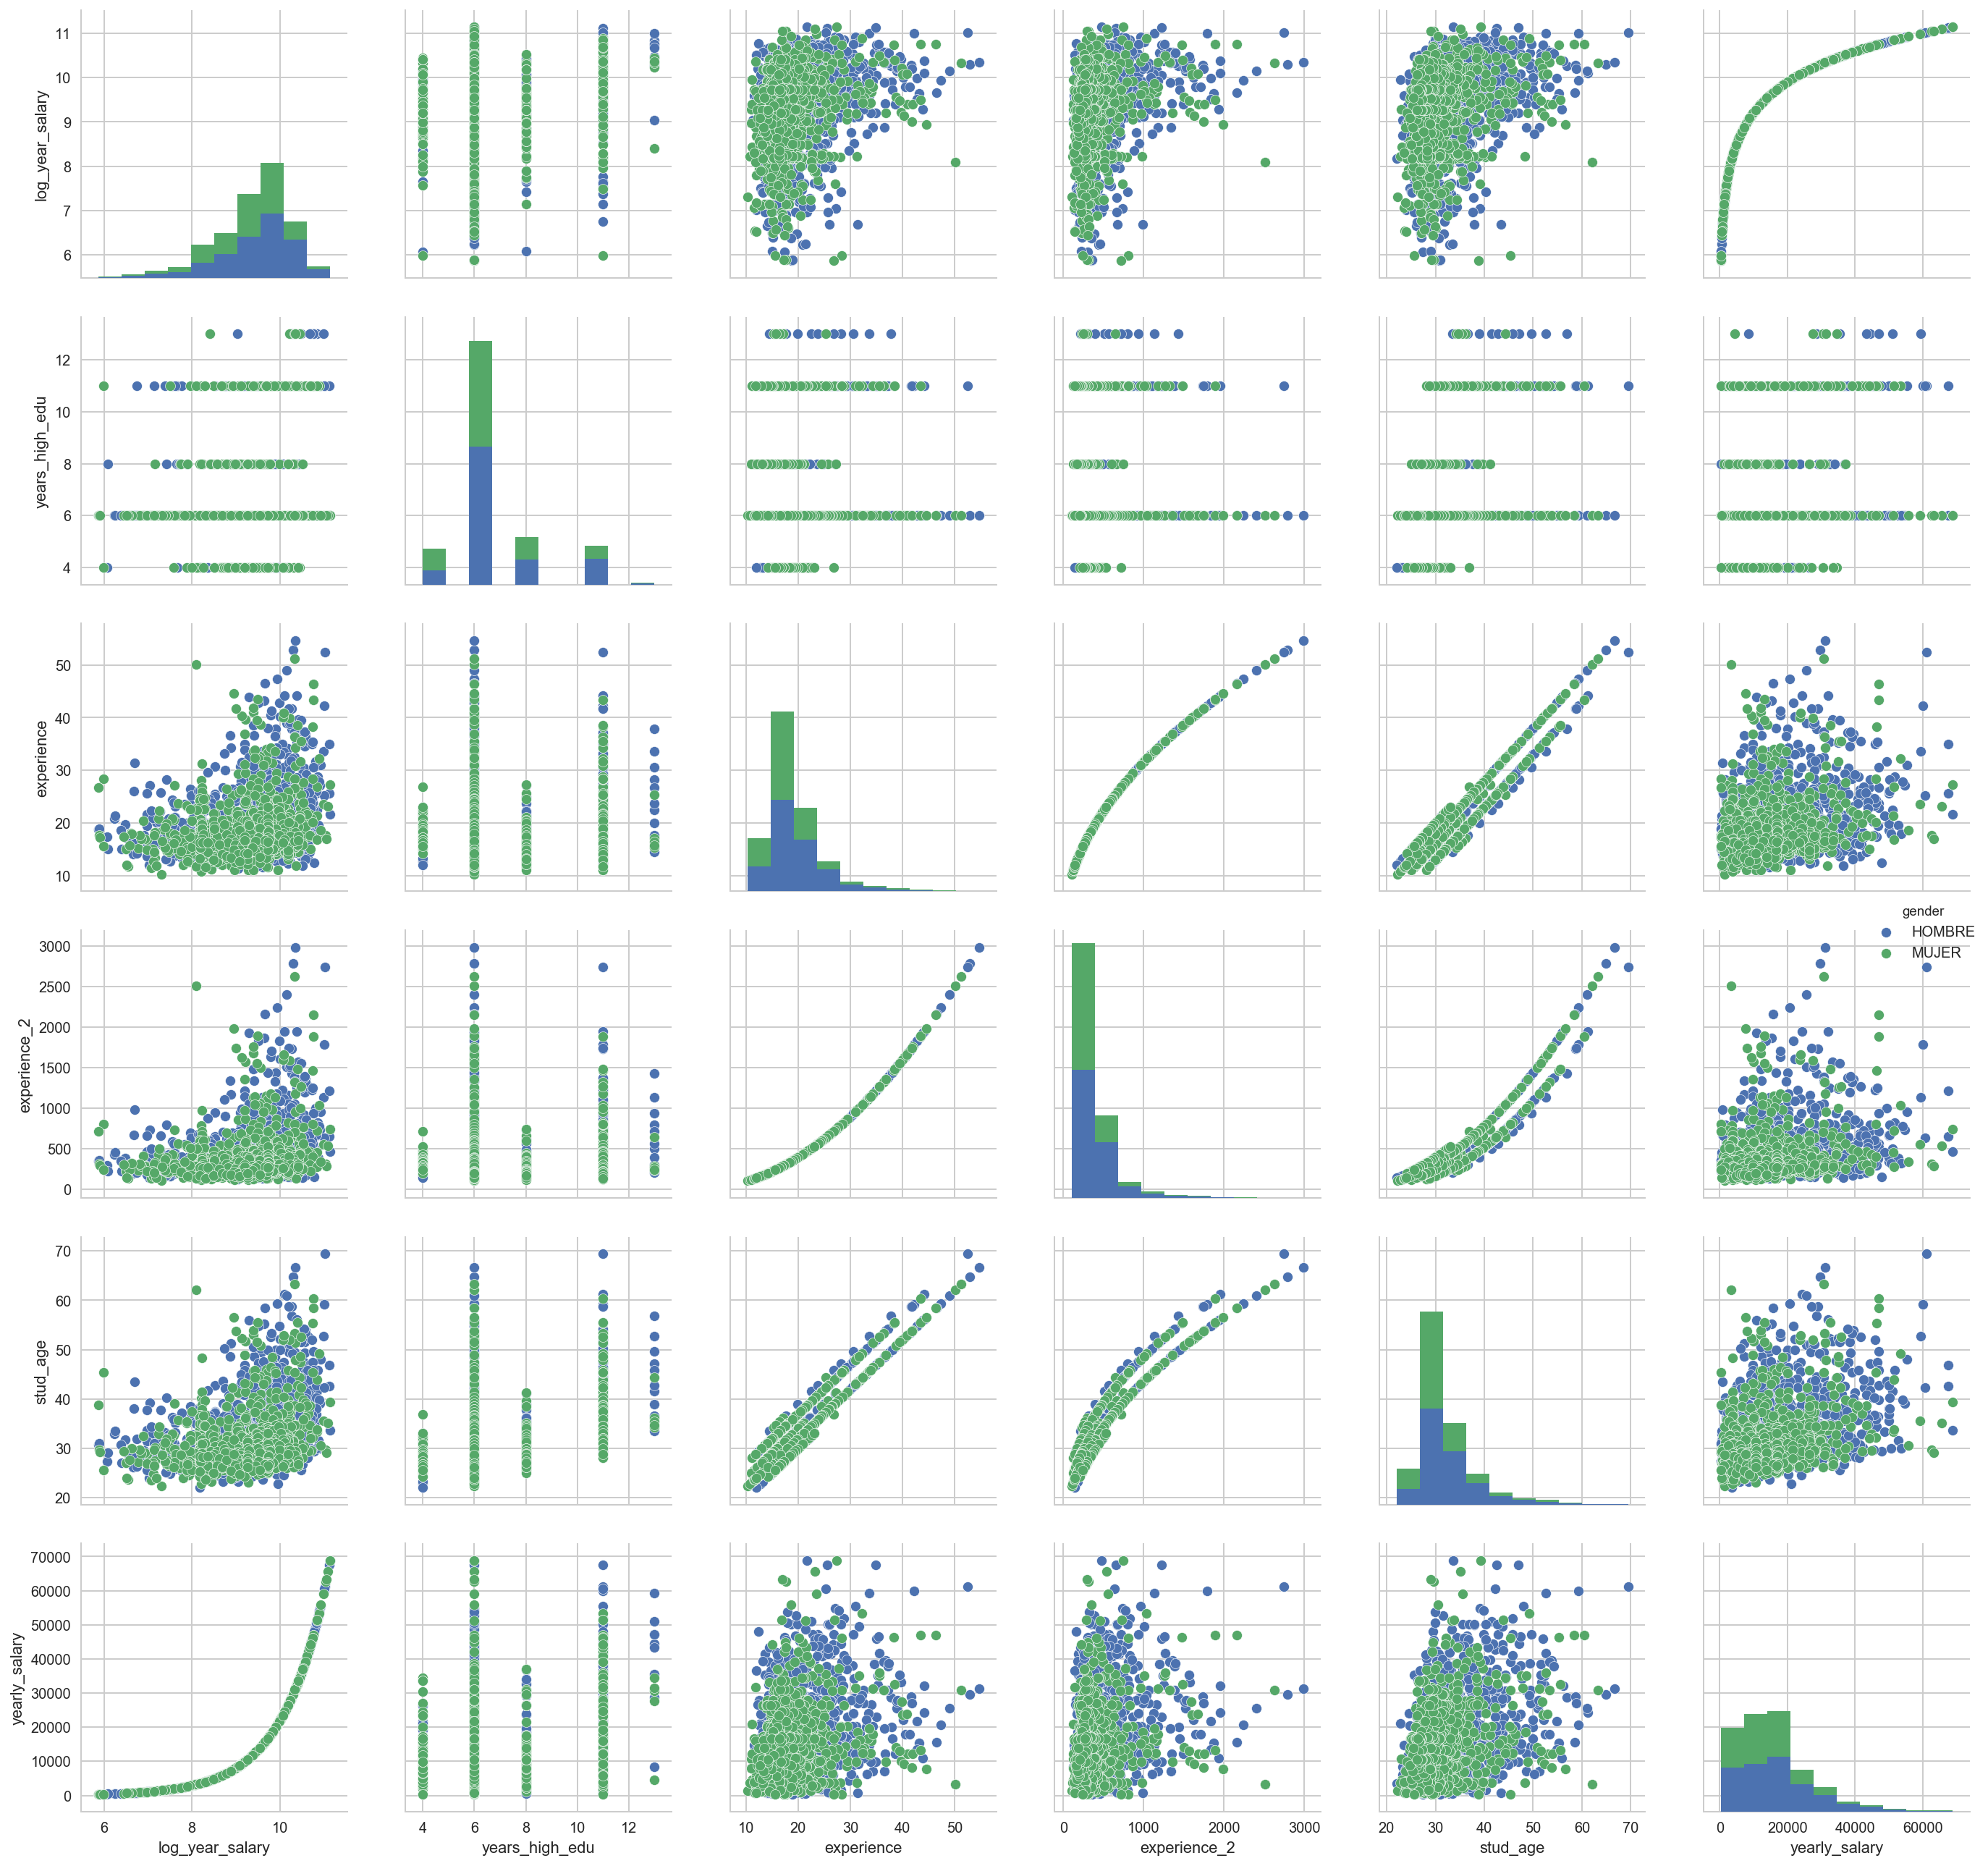

In [9]:
sns.pairplot(data=df, 
             vars=['log_year_salary', 'years_high_edu', 'experience', 'experience_2', 'stud_age', 'yearly_salary'], 
             hue='gender', size=3)
#hue is like a a dependent variable which is 0,1.
plt.tight_layout()
# plt.savefig('./figures/scatter_by_gender.png', dpi=300) ## undo this line if you want to save the graph
plt.show()

---
## Part 1.1 Correlation heat map set of variables from dataset

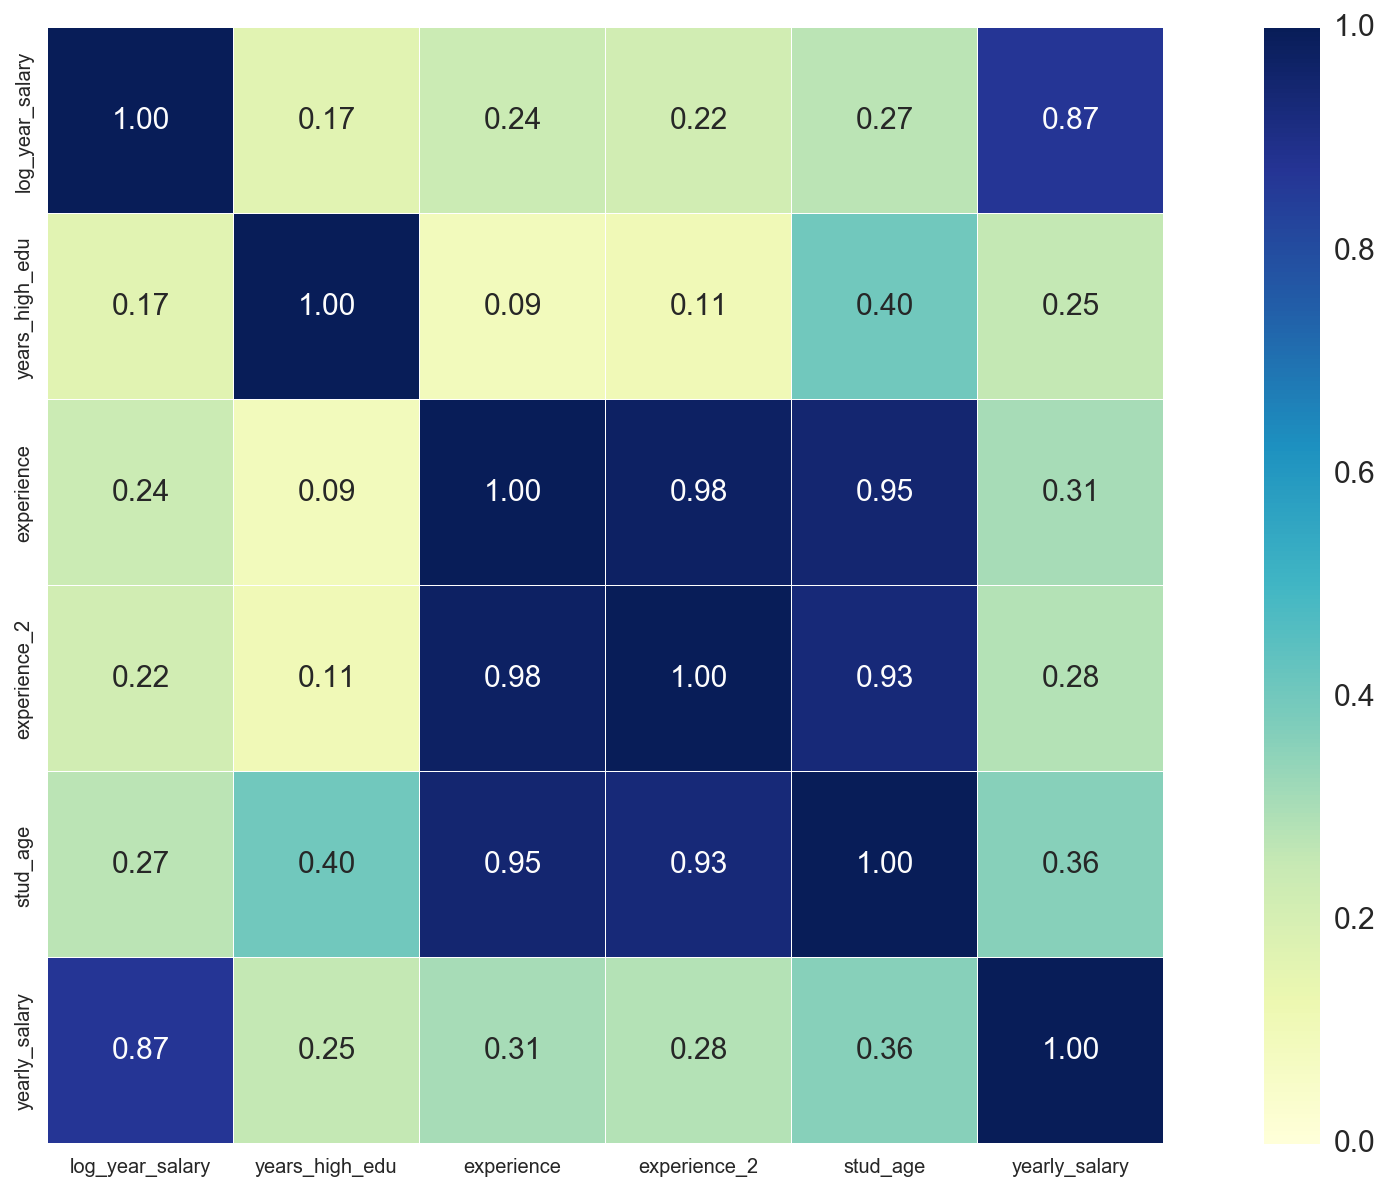

In [9]:
cols = ['log_year_salary', 'years_high_edu', 'experience', 'experience_2', 'stud_age', 'yearly_salary']
fig = plt.figure(figsize=(18,10))
ax = fig.gca()

cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 cmap="YlGnBu", 
                 vmin=0, 
                 vmax=1,
                 linewidths= .15, 
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols,
                 ax=ax)
plt.show()

---

## Part 2. Regularization
### For the next part we are using a dataset with large number of predictors
### Make predictor and target variables and normalize the predictors.

Why is normalization necessary for regularized regressions?

**ANS:** Normalization is necessary for regularized regression because the beta values for each predictor variable must be on the same scale. If betas are different sizes just because of the scale of predictor variables the regularization term can't determine which betas are more/less important based on their size.

There is a class in sklearn.preprocessing called `StandardScaler`. 

In [11]:
# here we regressing OLS dep variables on features: NB: ~ separates the dep var from the controls
# The line formula="' is essential because it will load allow to include string variables.
# C(variable) will just create categories of the dummy variable. 
# - 1 at the end removes the intercept
formula1 = '''
log_year_salary ~ years_high_edu, experience, experience_2, C(gender), stud_age, 
C(ethnicity), C(prov_resid), C(country_study), C(marital_status) -1
'''
formula1 = formula1.replace(",", "+")

In [16]:
from patsy import dmatrices
import patsy
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() ## We are going to normalize

y, X = patsy.dmatrices(formula1, data=df, return_type="dataframe") #to make sure our Y and X are into a matrix
y = np.ravel(y)


# use the "fit_transform" function to normalize the X design matrix
Xn = ss.fit_transform(X)

print (y.shape)
print ("\n=====\n")
print (Xn.shape) #it will print the Xs as columns

(2726L,)

=====

(2726L, 78L)


In [47]:
kobe = pd.read_csv('C:/Users/mjors_000/Desktop/ECON628-01-berenger92/datasets/kobe_bryant/kobe_superwide_games.csv')

In [48]:
print 'Number of Predictors in dataset:', len(kobe.columns)

Number of Predictors in dataset: 645


---

### Using Skelearn - build a linear regression predicting `shots_made` / `income`  from the rest of the columns.

### Using Skelearn - evaluate the performance of an OLS 

Cross-validate the $R^2$ of a linear regression model with 10 cross-validation folds.

Remember that it is neccesary to test the model on data that it hasn't seen during the training => best way to
get an unbiased estimate of the model's performance


How does it perform?

In [49]:
y = kobe.SHOTS_MADE.values
X = kobe.iloc[:,1:]

# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to normalize the X design matrix
Xn = ss.fit_transform(X)

## Print the shapes and types of your target and predictore
print (y.shape), (type(y))
print ("\n=====\n")
print (Xn.shape), (type(Xn))

(1558L,) <type 'numpy.ndarray'>

=====

(1558L, 644L) <type 'numpy.ndarray'>


# Now we are splitting the data into test and Train to regress.

In [50]:

## import packages 
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split #here we import test and train packages from skitlearn

## train_test_split splits arrays or matrices into random train and test subsets. That means that everytime you run it 
## without specifying random_state, you will get a different result, this is expected behavior.

Xtrain, Xtest, ytrain, ytest = train_test_split(Xn, y, test_size=0.30, random_state=10)
#what we did is separating the dataframe into test and train, by saying to the test size to be 30% of the data
print Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape 

## If you use random_state=some_number, then you can guarantee that your split will be always the same. 
## This is useful if you want reproducible results, for example 
## in testing for consistency in the documentation (so that everybody can see the same numbers).

(1090L, 644L) (468L, 644L) (1090L,) (468L,)


In [51]:
## define a linear regression model
lr = LinearRegression()

## fit your model
lr.fit(Xtrain, ytrain)


## predict values => you predict on the test, I am predict on the train so we can see how the model performs
ytrain_pred = lr.predict(Xtrain)
ytest_pred = lr.predict(Xtest)
# print(lr.coef_)
# print "====\n"

## Cross validate = 10
linreg_scores = cross_val_score(lr, Xtrain, ytrain, cv=10)

## Print the R^2
print linreg_scores
print "Average R^2 OLS score: %.3f" % (np.mean(linreg_scores))

[ -1.48500483e+28  -1.73865472e+28  -3.27760903e+28  -6.55962816e+28
  -8.54678678e+28  -2.03304072e+28  -1.74093219e+28  -1.76370961e+28
  -3.82493334e+28  -1.50987698e+28]
Average R^2 OLS score: -32480176374291186230725967872.000


In [52]:
# The mean R^2 is extremely negative. Almost all the R^2 scores are negative in crossvalidation.
# The linear regression is performing far worse than baseline, but how do we know if this is true with unseen datasets?
# It is probably dramatically overfitting and the redundant variables are affecting
# the coefficients in weird ways.

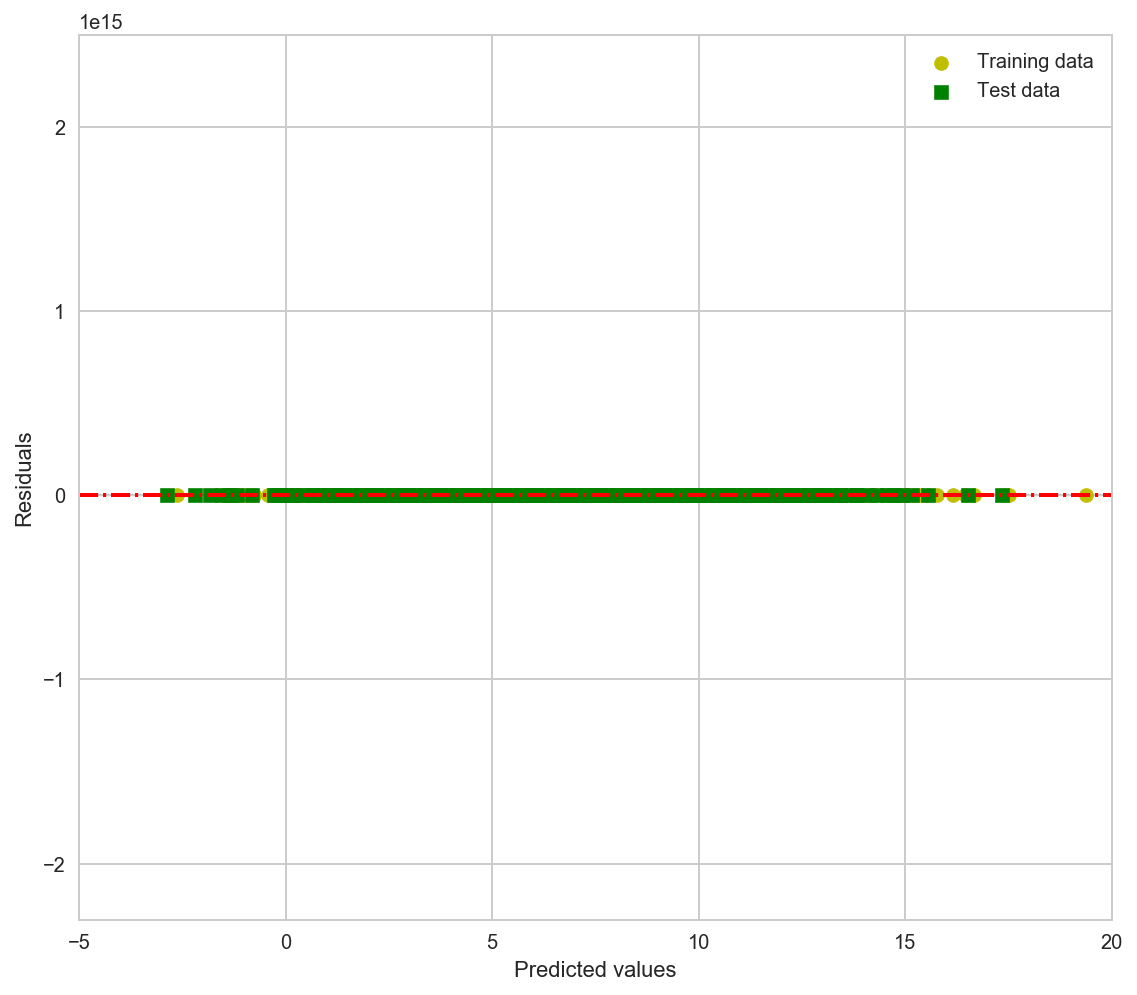

In [53]:
## Here we are plotting the residuals vs the predicted values for our train and test data set
## Recall residual plots are the graphical diagnosis to detect nonlinearity, outliers and and if the
## error terms are randomly distributed

fig = plt.figure(figsize=(8,7))

plt.scatter(ytrain_pred,  ytrain_pred - ytrain,
            c='y', marker='o', label='Training data')

plt.scatter(ytest_pred,  ytest_pred - ytest,
            c='g', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, xmin=-5, xmax=20, lw=2, linestyles= '-.', color='red')
plt.xlim([-5, 20])
plt.tight_layout()

plt.show()

In [54]:
## In the graph we see a "perfect prediction" = the residuals are exactly zero
## But rember that this graph doesn't tell the full story
## It looks like we are overfitting our model

In [55]:
## Use the R^2 and MSE to see how the model is performing on train and test data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE - OLS train: %.3f, test: %.3f' % (
        mean_squared_error(ytrain, ytrain_pred), #ytest_pred and ytrain_pred were created above
        mean_squared_error(ytest, ytest_pred)))
print('R^2 0LS train: %.3f, test: %.3f' % (
        r2_score(ytrain, ytrain_pred),
        r2_score(ytest, ytest_pred)))

MSE - OLS train: 2.563, test: 127644884001231150361654329344.000
R^2 0LS train: 0.773, test: -9283153321501031660125159424.000


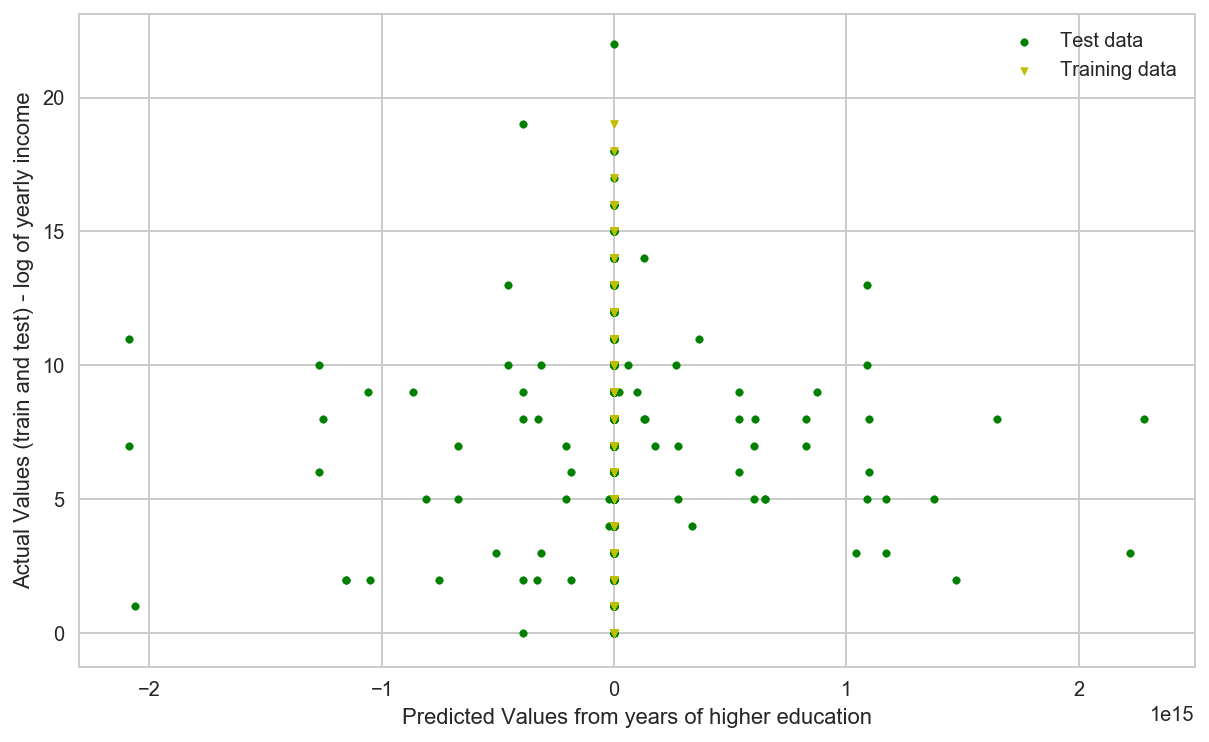

In [57]:
## Here we are plotting the predicted values for our train and test data set
fig = plt.figure(figsize=(10,6))
plt.scatter(ytest_pred, ytest, s=14, c='g', marker='o', label='Test data')
plt.scatter(ytrain_pred, ytrain, s=14, c='y', marker='v', label='Training data')
plt.xlabel("Predicted Values from years of higher education")
plt.ylabel("Actual Values (train and test) - log of yearly income")
plt.legend(loc='upper right')
plt.show()

---
## Using regularized methods for regression

### Find an optimal value for Ridge regression alpha using RidgeCV

[Go to the documentation and read how RidgeCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

Hint: once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.

Recall that Ridge performs best searching alphas through logarithmic space (`np.logspace`).


In [58]:
# import packages for regularization function
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

In [59]:
ridge_alphas = np.logspace(0, 5, 200) 
# here we are finding the ridge alpha value by starting with a range to find out the value

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10) 
#cv= cross validate..always do it..to run on 10 different random samples
optimal_ridge.fit(Xtrain, ytrain)
print (optimal_ridge.alpha_)

1231.55060329


In [60]:
## Implement the Ridge Regression
ridge = Ridge(alpha=optimal_ridge.alpha_)

## Fit the Ridge regression
ridge.fit(Xtrain, ytrain)
ytrain_pred_ridge = ridge.predict(Xtrain)
ytest_pred_ridge = ridge.predict(Xtest)
# print(ridge.coef_)
# print "=====\n"


## Cross validate = 10
ridge_scores = cross_val_score(ridge, Xtrain, ytrain, cv=10)
## Print the R^2
print ridge_scores
print "Average R^2 Ridge score: %.3f" % (np.mean(ridge_scores))

[ 0.62733064  0.65278277  0.56214553  0.52024955  0.66036061  0.53273611
  0.60157141  0.59769571  0.63754949  0.57678393]
Average R^2 Ridge score: 0.597


# N.B: WE COMPARE THE AVERAGE R-SQUARED and MEAN SQUARED ERROR OF OLS, RIDGE AND LASSO, AND COMPARE.
# AND LOOK AT WHICH ONE DOES BEST EXPLAIN THE DATASET.

In [61]:
print('MSE - Ridge train: %.3f, test: %.3f' % (
        mean_squared_error(ytrain, ytrain_pred_ridge),
        mean_squared_error(ytest, ytest_pred_ridge)))
print('R^2 - Ridge train: %.3f, test: %.3f' % (
        r2_score(ytrain, ytrain_pred_ridge),
        r2_score(ytest, ytest_pred_ridge)))

MSE - Ridge train: 2.716, test: 4.763
R^2 - Ridge train: 0.760, test: 0.654


---

### Find an optimal value for Lasso regression alpha using LassoCV

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) It is very similar to RidgeCV.

Hint: again, once the LassoCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.

Recall that Lasso, unlike Ridge, performs best searching alphas through linear space (`np.linspace`). However, you can actually let the LassoCV decide itself what alphas to use by instead setting the keyword argument `n_alphas=` to however many alphas you want it to search over.

In [62]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xtrain, ytrain)

print optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0926799261629


In [63]:
## Implement the Lasso Regression
lasso = Lasso(alpha=optimal_lasso.alpha_)

## fit your regression
lasso.fit(Xtrain, ytrain)
ytrain_pred_lasso = lasso.predict(Xtrain)
ytest_pred_lasso = lasso.predict(Xtest)
# print(lasso.coef_)
# print "====\n"

lasso_scores = cross_val_score(lasso, Xtrain, ytrain, cv=10)
print lasso_scores
print "Average R^2 Lasso score: %.3f" % (np.mean(lasso_scores))

[ 0.65071198  0.69432185  0.5922647   0.5539987   0.65228187  0.54999685
  0.63819587  0.61563171  0.64804754  0.61834179]
Average R^2 Lasso score: 0.621


In [67]:
#WE SEE THAT THE AVERAGE R-SQUARE LASSO IS BETTER THAN RIDGE (62%>59%)

In [66]:
print('MSE - Lasso train: %.3f, test: %.3f' % (
        mean_squared_error(ytrain, ytrain_pred_lasso),
        mean_squared_error(ytest, ytest_pred_lasso)))
print('R^2 - Lasso train: %.3f, test: %.3f' % (
        r2_score(ytrain, ytrain_pred_lasso),
        r2_score(ytest, ytest_pred_lasso)))

MSE - Lasso train: 3.483, test: 4.395
R^2 - Lasso train: 0.692, test: 0.680


---

### Find an optimal value for Elastic Net regression alpha using ElasticNetCV

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:

    alpha: strength of regularization
    l1_ratio: amount of ridge vs. lasso (0 = all ridge, 1 = all lasso)
    
Do not include 0 in the search for l1_ratio: it will not allow it and break!

You can use n_alphas for the alpha parameters instead of setting your own values: highly recommended!

Also - be careful setting too many l1_ratios over cross-validation folds in your search. It can take a very long time if you choose too many combinations and for the most part there are diminishing returns in this data.

In [68]:
l1_ratios = np.linspace(0.01, 1.0, 50)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=300, cv=5,
                            verbose=1)
optimal_enet.fit(Xtrain, ytrain)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0993542728234
1.0


In [69]:
##  Create a model Enet
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

## Fit your model
enet.fit(Xtrain, ytrain)

## predict
ytrain_pred_enet = enet.predict(Xtrain)
ytest_pred_enet = enet.predict(Xtest)
# print(enet.coef_)
# print "=====\n"

## Cross validate the scores and print the mean of the scores
enet_scores = cross_val_score(enet, Xtrain, ytrain, cv=10)
print enet_scores
print "Average R^2 ElasticNet score: %.3f" % (np.mean(enet_scores))

[ 0.65203145  0.69130907  0.59282605  0.55605774  0.65249402  0.54999752
  0.63823935  0.61292995  0.64687086  0.61920209]
Average R^2 ElasticNet score: 0.621


In [70]:
print('MSE - ElasticNet train: %.3f, test: %.3f' % (
        mean_squared_error(ytrain, ytrain_pred_enet),
        mean_squared_error(ytest, ytest_pred_enet)))
print('R^2 - ElasticNet train: %.3f, test: %.3f' % (
        r2_score(ytrain, ytrain_pred_enet),
        r2_score(ytest, ytest_pred_enet)))

MSE - ElasticNet train: 3.562, test: 4.406
R^2 - ElasticNet train: 0.685, test: 0.680


In [71]:
#fOR THE DATASET STUDENTS we see that the Elastic Net is not outperforming the other methods Ridge and Lasso, 
#because the MSE and R-squared are same

#FOR THE KIGO DATASET, WE SEE THAT LASSO AND ELASTIC NET ARE PRETTY CLOSE, SO WE CAN CHOOSE ONE OF THE TWO

---

### Visualize the residuals on the training and test data

In [39]:
# model residuals on training data:
ols_resd_train  = ytrain - ytrain_pred
ridge_resd_train = ytrain - ytrain_pred_ridge
lasso_resd_train = ytrain - ytrain_pred_lasso
enet_resd_train = ytrain - ytrain_pred_enet


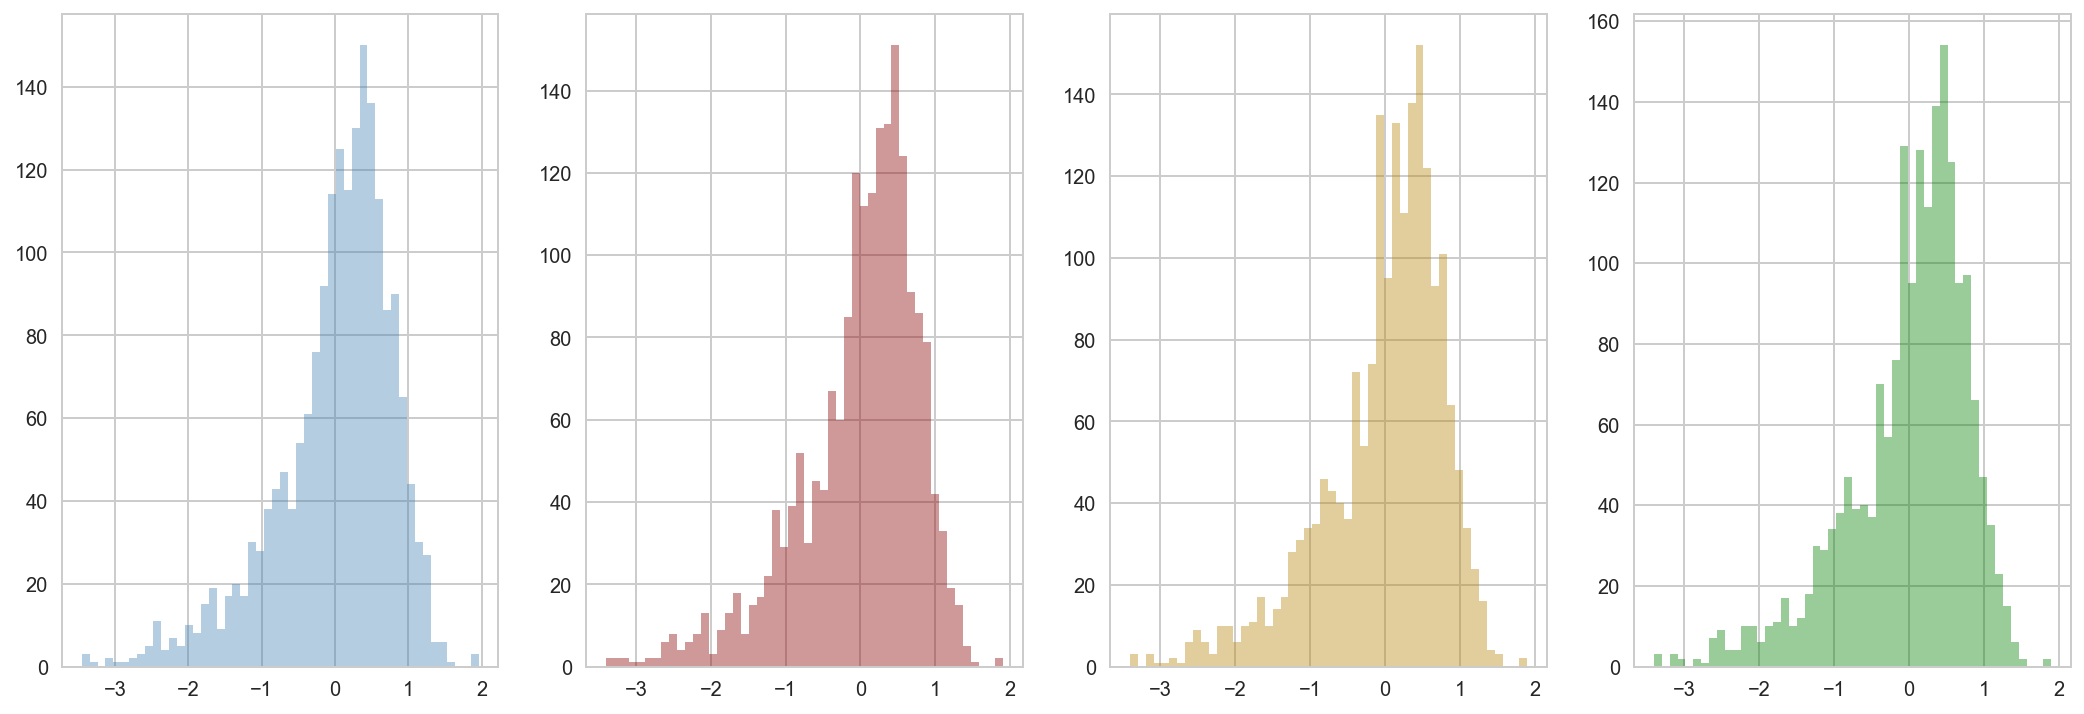

In [40]:
fig, axarr = plt.subplots(1, 4, figsize=(18, 6))

sns.distplot(ols_resd_train, bins=50, hist=True, kde=False, 
             color='steelblue', ax=axarr[0], label='OLS residuals')


sns.distplot(ridge_resd_train, bins=50, hist=True, kde=False, 
             color='darkred', ax=axarr[1], label='Ridge residuals')


sns.distplot(lasso_resd_train, bins=50, hist=True, kde=False, 
             color='darkgoldenrod', ax=axarr[2], label='Lasso residuals')

sns.distplot(enet_resd_train, bins=50, hist=True, kde=False, 
             color='g', ax=axarr[3], label='ElasticNet residuals')

plt.show()


In [41]:
# model residuals on test data:
ols_resd_test  = ytest - ytest_pred
ridge_resd_test = ytest - ytest_pred_ridge
lasso_resd_test = ytest - ytest_pred_lasso
enet_resd_test = ytest - ytest_pred_enet

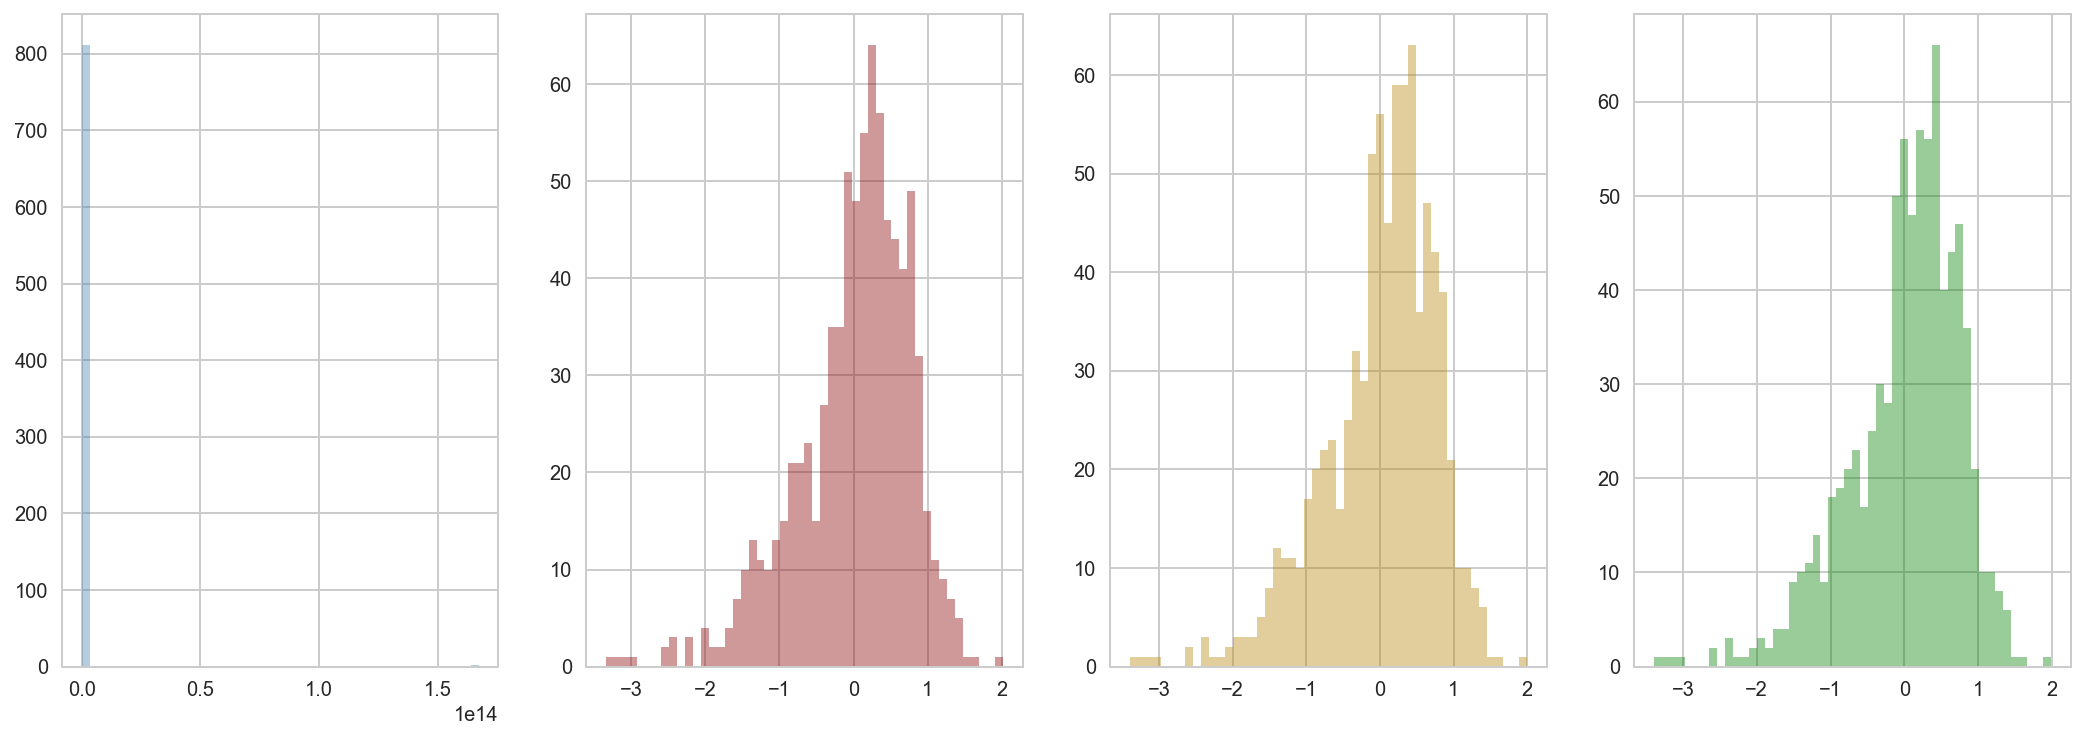

In [42]:
fig, axarr = plt.subplots(1, 4, figsize=(18, 6))

sns.distplot(ols_resd_test, bins=50, hist=True, kde=False, 
             color='steelblue', ax=axarr[0], label='OLS residuals')


sns.distplot(ridge_resd_test, bins=50, hist=True, kde=False, 
             color='darkred', ax=axarr[1], label='Ridge residuals')


sns.distplot(lasso_resd_test, bins=50, hist=True, kde=False, 
             color='darkgoldenrod', ax=axarr[2], label='Lasso residuals')

sns.distplot(enet_resd_test, bins=50, hist=True, kde=False, 
             color='g', ax=axarr[3], label='ElasticNet residuals')

plt.show()


In [43]:
#we see that the 1st one OLS residuals distribution is not normal, as compared to the the other Ridge Lasso Elastic.
#So we have to assume one of the other techniques is best

In [44]:
''' Function to print the coefficients, their absolute values and the non-absolute values'''
def best_reg_method(X, best_regulari):
    method_coefs = pd.DataFrame({'variable':X.columns, 
                                 'coef':best_regulari.coef_, 
                                 'abs_coef':np.abs(best_regulari.coef_)})
    method_coefs.sort_values('abs_coef', inplace=True, ascending=False)
    '''you can change the number inside head to display more or less variables'''
    return method_coefs.head(10)

In [45]:
#HERE WE CHOOSE/SPECIFY THE BEST METHOD, AND THAT WILL DISPLAY THE VARIABLES
best_reg_method(X,lasso ) 

,abs_coef,coef,variable
77,0.156168,0.156168,stud_age
31,0.087285,-0.087285,C(country_study)[T.AUSTRALIA]
71,0.080101,-0.080101,C(marital_status)[T.SOLTERO]
74,0.041849,0.041849,years_high_edu
65,0.040808,-0.040808,C(country_study)[T.SUECIA]
35,0.038353,-0.038353,C(country_study)[T.BRASIL]
46,0.038261,-0.038261,C(country_study)[T.ESTADOS UNIDOS DE AMERICA]
24,0.035937,0.035937,C(prov_resid)[T.PICHINCHA]
41,0.029606,0.029606,C(country_study)[T.CUBA]
30,0.028950,-0.028950,C(country_study)[T.ARGENTINA]


In [ ]:
#HERE WE CHOOSE/SPECIFY THE BEST METHOD, AND THAT WILL DISPLAY THE VARIABLES
best_reg_method(X,enet ) #this is for elastic net